# QSPRpred API Integration with LangChain Agent

This notebook demonstrates the integration of the BridgeDB API with a LangChain-powered AI agent for biological identifier mapping.

## Table of Contents
1. Setup and Imports
2. Papyrus API Wrapper
3. Custom LangChain Tool
4. AI Agent Configuration
5. Testing the Agent
6. Additional Utility Functions
7. Direct API Calls

## 1. Setup and Imports

First, let's set up our environment and import the necessary libraries.

In [1]:
# Import statements
import os
import requests
import pandas as pd
from dotenv import load_dotenv
from langchain_community.tools import BaseTool
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

from qsprpred.data.sources.papyrus import Papyrus
import qsprpred

# Load environment variables
load_dotenv()

# Set OpenAI API Key
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("OpenAI API Key is not set. Please check your .env file.")

os.environ["OPENAI_API_KEY"] = api_key

dataset_name = "PapyrusTutorialDataset"  # name of the file to be generated
papyrus_version = "latest"  # Papyrus database version
data_dir = "papyrus"  # directory to store the Papyrus data
output_dir = "data"  # directory to store the generated dataset

In [ ]:
# from papyrus_scripts.download import download_papyrus
# download_papyrus(version='latest', structures=True, descriptors=['mold2', 'unirep'])

### Practice dataset

First we'll create a test dataset for validating the results for the dataset retriever

In [3]:
from qsprpred.data.sources.papyrus import Papyrus
import qsprpred

acc_keys = ["P29274"]
dataset_name = "PapyrusTutorialDataset"  # name of the file to be generated
quality = "high"  # choose minimum quality from {"high", "medium", "low"}
papyrus_version = "latest"  # Papyrus database version
data_dir = "papyrus"  # directory to store the Papyrus data
output_dir = "data"  # directory to store the generated dataset

# Create a Papyrus object, which specifies the version and directory to store the payrus data
papyrus = Papyrus(
    data_dir=data_dir,
    version=papyrus_version,
    stereo=False,
    plus_only=True,
)

# Create subset of payrus data for the given accession keys, returns a MoleculeTable
mt = papyrus.getData(
    dataset_name,
    acc_keys,
    quality,
    output_dir=output_dir,
    use_existing=False,
    activity_types=["Ki", "IC50", "Kd"]
)
mt.getDF().head()

len(mt.getDF())

0it [00:00, ?it/s]

3785

## 2. QSPRpred API Wrapper

We'll create a wrapper class for the QSPRpred API to handle identifier mapping requests.

In [19]:
from qsprpred.data import QSPRDataset, RandomSplit
from qsprpred.data.descriptors.fingerprints import MorganFP
from qsprpred.models import SklearnModel, SklearnMetrics
from qsprpred.models import CrossValAssessor
from sklearn.ensemble import RandomForestRegressor
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np

# PapyrusAPI Class
# This class encapsulates the functionality to interact with the Papyrus database:

class PapyrusAPI:
    papyrus_version = "latest"  # Papyrus database version
    data_dir = "papyrus"  # directory to store the Papyrus data
    output_dir = "data"  # directory to store the generated dataset


    @staticmethod
    def fetch_data(acc_keys, quality):
        papyrus = Papyrus(
                data_dir=data_dir,
                version=papyrus_version,
                stereo=False,
                plus_only=True,
            )
        # create subset
        mt = papyrus.getData(
                dataset_name,
                acc_keys,
                quality,
                output_dir=output_dir,
                use_existing=False,
                activity_types=["Ki", "IC50", "Kd"]
            )
        if type(mt) is qsprpred.data.tables.mol.MoleculeTable:
            return mt
        else:
             f"Error: fetched data is {type(mt)}, should be MoleculeTable "

class QSPRpredAPI:
    @staticmethod
    def prepare_dataset(papyrus_set):
        # calculate features of compounds in dataset and split dataset into train and test
        dataset = QSPRDataset.fromMolTable(
            papyrus_set,
            name="AssessmentTutorialDataset",
            target_props=[{"name": "pchembl_value_Mean", "task": "REGRESSION"}],
            random_state=42
        )

        dataset.prepareDataset(
            split=RandomSplit(test_fraction=0.2, dataset=papyrus_set),
            feature_calculators=[MorganFP(radius=3, nBits=2048)],
            recalculate_features=True,
        )

        return dataset
    
    @staticmethod
    def evaluate_model(dataset):    
        # Initialize random forest it with the SklearnModel class
        model = SklearnModel(
            base_dir="models",
            alg=RandomForestRegressor,
            name="AgentTestModel",
        )

        # Set the scoring metric to use
        metric = "r2"

        # Train and evaluate the model
        scores = CrossValAssessor(metric)(model, dataset)

        return model, scores

    @staticmethod
    def fit_model(model, dataset):  
        model.fitDataset(dataset)

        return model


## 3. Custom LangChain Tool

Now, let's create a custom LangChain tool that uses our BridgeDbAPI wrapper.

In [43]:
# define papyrus dataset handler   

class PapyrusDatasetThresholdTool(BaseTool):
    name: str ="dataset_threshold"
    description: str = "Used when no existing model is available"

    def checkSMILES(self, smiles):
        # check if a valid compound smiles is given and if not, do not proceed
        if not Chem.MolFromSmiles(smiles):
            return f"Invalid SMILES found: {smiles}"

    def _run(self, query: str) -> str:
        # Parse the query; now expecting only three parts: acc_keys, quality, smiles
        parts = query.split(",")
        if len(parts) != 3:
            return "Error: Query should be in the format 'acc_keys, quality, smiles"
        acc_keys, quality, smiles = [p.strip() for p in parts]
        

        # Attempt to determine the potency of a compound if conditions, like number of rows and model performance are met
        try:
            # check if a valid compound smiles is given and if not, do not proceed
            self.checkSMILES(smiles)
            
            # fetch data
            papyrus_set = PapyrusAPI().fetch_data(acc_keys, quality)
            num_rows = len(papyrus_set)
            threshold = 1000
            # determine if number of rows is higher than threshold
            if num_rows < float(threshold):
                return f"number of rows {num_rows} is lower than threshold"
            else:
                # number of rows is higher than theshold, so proceed to evaluate the model
                dataset = QSPRpredAPI.prepare_dataset(papyrus_set)
                model, scores = QSPRpredAPI.evaluate_model(dataset)
                
                avg_score = sum(scores)/len(scores)
                score_threshold = 0.6
                
                # make a figure of the evaluation results
                fig, ax = plt.subplots()
                ax.bar(acc_keys, avg_score, yerr=np.std(scores))

                ax.set_title('R-squared')

                # assess if the cross validation score is higher than the threshold for accurate potency predictions
                if avg_score > score_threshold:
                    # Finally, we need to fit the model on the complete dataset if we want to use it further
                    model = QSPRpredAPI.fit_model(model, dataset)

                    # predict the potency of compound based on SMILES
                    predictions = model.predictMols([smiles])
                    # return the predicted potency and the figure of cross validation results
                    return predictions, fig
                else:
                    return f"The average cross validation score of {avg_score} is too low to make accurate potency predictions"
            # print(result.getDF().Quality.value_counts())
        except Exception as e:
            return f"Error: {str(e)}"

    def _arun(self, query: str) -> str:
        # Async implementation (not needed for this tool)
        raise NotImplementedError("This tool does not support async")
    
tools = [PapyrusDatasetThresholdTool()]

0it [00:00, ?it/s]

(array([[6.287395]]), <Figure size 640x480 with 1 Axes>)

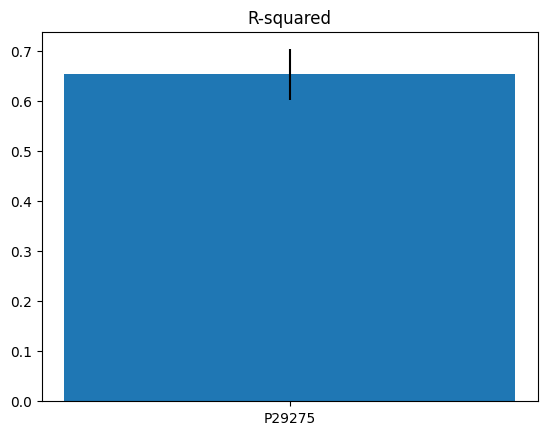

In [21]:
# Test with a different ENSG identifier (e.g., BRCA2)
tool = PapyrusDatasetThresholdTool()
tool._run("P29275, high, CCCCCC")

In [34]:
import requests


class CloudmodelsAPI:
    @staticmethod
    def predict(smiles, acc_key, architecture):
        # initiate a prediction and receive the results in JSON format, use:
        headers = {
            'Content-Type': 'application/json',
        }

        model = f'{acc_key}_{architecture}_Model'

        json_data = {
            'smiles': [
                smiles
            ],
            'models': [
                model
            ],
            'format': 'text',
        }

        response = requests.post('https://qsprpred.cloud.vhp4safety.nl/api', headers=headers, json=json_data)

        return response.text


In [44]:
class PretrainedPredictTool(BaseTool):
    name: str ="pretrained_predict"
    description: str = "Useful for predicting potency of compound with a pretrained model"

    def _run(self, query: str) -> str:
        # Parse the query; now expecting only three parts: smiles, acc_key, architecture
        parts = query.split(",")
        if len(parts) != 3:
            return "Error: Query should be in the format 'smiles, acc_key, architecture'"
        smiles, acc_key, architecture = [p.strip() for p in parts]
        
        # Attempt to predict potency
        try:
            result = CloudmodelsAPI().predict(smiles, acc_key, architecture)
            return result
            # if isinstance(result, list):
            #     # Formatting the output as a list
            #     formatted_result = "\n".join([f"- {item}" for item in result])
            #     return f"Mapped identifiers:\n{formatted_result}"
            # else:
            #     return f"Error: {result}"  # This handles non-list responses like error messages
        except Exception as e:
            return f"Error: {str(e)}"

In [37]:
tool = PretrainedPredictTool()
tool._run("CCCC, P10827, RF")

'SMILES: CCCC -> prediction (P10827_RF_Model): 5.9564'

## 4. AI Agent Configuration

Let's set up our AI agent using the custom tool we created.

Query: I want to predict the potency of compound with SMILES CCCC with an existing RF model for P10827. If there is no model report back and train a model with data of quality high

----
----
----
----
The predicted potency of the compound with SMILES "CCCC" using the existing RF model for P10827 is approximately 5.9564.
----


Query: I want to predict the potency of compound with SMILES CCCC with an existing RF model for P29275. If there is no model report back and train a model with data of quality high

----
----
----
----
----


0it [00:00, ?it/s]

----
The existing RF model for P29275 does not exist. However, I have trained a new model using high-quality data, and the predicted potency for the compound with SMILES "CCCC" is approximately 6.34.
----




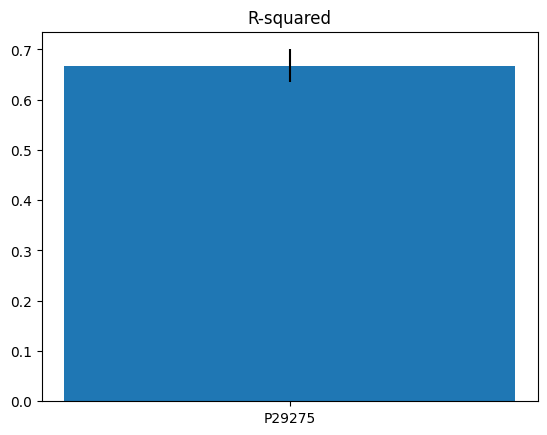

In [47]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage

def create_bridgedb_agent():
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    tools = [PretrainedPredictTool(), PapyrusDatasetThresholdTool()]
    memory = MemorySaver()
    agent_executor = create_react_agent(model, tools, checkpointer=memory)
    return agent_executor

papyrus_agent = create_bridgedb_agent()

def run_agent_query(query):
    config = {"configurable": {"thread_id": "qspr_conversation"}}
    
    print(f"Query: {query}\n")
    for chunk in papyrus_agent.stream(
        {"messages": [HumanMessage(content=query)]},
        config
    ):
        if 'agent' in chunk and 'messages' in chunk['agent']:
            for message in chunk['agent']['messages']:
                if hasattr(message, 'content') and message.content:
                    print(message.content)
        print("----")
    print("\n")

# Test queries

run_agent_query("I want to predict the potency of compound with SMILES CCCC with an existing RF model for P10827. If there is no model train a model with data of quality high. Report whether a pretrained or a newly made model was used")
# run_agent_query("I want to predict the potency of compound with SMILES CCCC with an existing RF model for P29275. If there is no model report back and train a model with data of quality high")